# Classification of Leukemic Cells. Model trained from scratch

## Loading the libraries

In [1]:
#Load libraries
import os
import io
import glob
import numpy as np
import pathlib
import imageio
from sklearn.metrics import confusion_matrix

#Plot Modules
import matplotlib.pyplot as plt
import pandas as pd


#Pytorch Modules 
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import (Dataset,DataLoader) 
from torchsummary import summary
import torch.nn.functional as F
from torch.nn.modules.loss import BCEWithLogitsLoss

#Tensor Board Modules
from torch.utils.tensorboard import SummaryWriter



print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.0.dev20220830
Torchvision Version:  0.14.0.dev20220830


## Helper Functions

### Function 1: Plotting function

In [2]:
def plot(n_images,loader = None):
    fig = plt.figure(figsize=(6*n_images, 5*n_images))
    rows = 4
    columns = 4
        
    #Transforming the images to tensor objects
    if loader == None:
        transformer_get_mean = transforms.Compose([transforms.ToTensor()]) #Tensor Parameters
        sample_set = torchvision.datasets.ImageFolder(train_path,transform=transformer_get_mean) #Defining the sample
        loader = DataLoader(dataset = sample_set,batch_size=n_images, shuffle=True) #Defining a loader
    else:
        loader = loader      

    images, labels = next(iter(loader))
    for i in range(1,n_images,2):
        
        #getting cell image
        image = np.transpose(images[i].numpy(), (1, 2, 0))
        
        fig.add_subplot(rows, columns, i)
        
        #Adding cell plot
        plt.imshow(image)
        plt.colorbar()
        plt.title("Sample Image")
        
        
        #Adding histogram plot
        fig.add_subplot(rows, columns, i+1)
        plt.hist(image.ravel(), bins=60, density=True)
        plt.xlabel("Values of Pixel")
        plt.ylabel("Frequency for relative")
        plt.title("Pixel Distribution")

### Function 2 and 3: Pixel mean and stardard deviation of a batch of images

In [3]:
#A function to determine the mean and stardard deviation of an image
def mean_std(loader):
    images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std


#A function to determine the mean and stardard deviation of a batch of n_images
def get_mean_std(n_images, loader = None):
    avg_mean = torch.Tensor([0.0,0.0,0.0])
    avg_std = torch.Tensor([0.0,0.0,0.0])
    
    #Transforming the images to tensor objects
    if loader == None:
        transformer_get_mean = transforms.Compose([transforms.ToTensor()]) #Tensor Parameters
        sample_set = torchvision.datasets.ImageFolder(train_path,transform=transformer_get_mean) #Defining the sample
        loader = DataLoader(dataset = sample_set,batch_size=n_images, shuffle=True) #Defining a loader
    else:
        loader = loader
    
    for i in range(n_images):
        mean, std = mean_std(loader)
        avg_mean = torch.add(avg_mean,mean)
        avg_std = torch.add(avg_std, std)
    avg_mean = torch.div(avg_mean, n_images)
    avg_std = torch.div(avg_std , n_images)
    return avg_mean, avg_std

### Function 4 and 5: Learning over a set of parameters (Grid Search)

In [4]:
from tqdm import tqdm

#Defining the Learning Functions:

def make_train_step(model, optimizer, loss_fn):
      def train_step(x,y):
        #make prediction
        yhat = model(x)
        #enter train mode
        model.train()
        #compute loss
        loss = loss_fn(yhat,y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #optimizer.cleargrads()

        return loss
      return train_step

def grid_search_optimization(optimizer):
    losses = []
    val_losses = []
    epoch_train_losses = []
    epoch_test_losses = []
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = [0.0]
    models = []


    for epoch in range(n_epochs):
        epoch_loss = 0
        train_accuracy=0.0
        test_accuracy=0.0
        for i ,data in tqdm(enumerate(trainloader), total = len(trainloader)): #iterate ove batches
            x_batch , y_batch = data
            x_batch = x_batch.to(device) #move to gpu
            y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
            y_batch = y_batch.to(device) #move to gpu


            loss = train_step(x_batch, y_batch)
            epoch_loss += loss/len(trainloader)
            pred = model(x_batch)
            predicted_vals = pred > 0
            train_accuracy+=int(torch.sum(predicted_vals==y_batch.data))
            losses.append(loss)
        epoch_train_losses.append(epoch_loss)

        train_accuracy=train_accuracy/train_count
        train_acc.append(train_accuracy)
        train_loss.append(float(epoch_loss))

        print('\nEpoch : {}, train loss : {}, train_accuracy = {}'.format(epoch+1,epoch_loss,train_accuracy))

      #validation doesnt requires gradient
        with torch.no_grad():
            cum_loss = 0
            for x_batch, y_batch in testloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
                y_batch = y_batch.to(device)

                #model to eval mode
                model.eval()

                yhat = model(x_batch)
                val_loss = loss_fn(yhat,y_batch)
                cum_loss += loss/len(testloader)
                val_losses.append(val_loss.item())

                predicted_vals = yhat > 0
                test_accuracy+=int(torch.sum(predicted_vals==y_batch.data))

            
            best_acc = max(test_acc)
            epoch_test_losses.append(cum_loss)
            test_accuracy=test_accuracy/test_count
            test_loss.append(float(cum_loss))
            test_acc.append(test_accuracy)
        

            

            print('Epoch : {}, val loss : {}, test accuracy =  {}'.format(epoch+1,cum_loss, test_accuracy))  


            #save best model
            if test_accuracy >= best_acc:
                torch.save(model, 'best-model.pt') #saving the best model
                top_acc = test_accuracy
                
    
    best_model = torch.load('best-model.pt')    
    return [float(top_acc), train_loss, test_loss, train_acc, test_acc, best_model]

### Function 6: Testing The Model Performance

In [5]:
def test_model(model,dataloaders,device):
    CM=0
    model.eval()
    with torch.no_grad():
        test_accuracy=0
        for x_batch, y_batch in testloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.unsqueeze(1).float() #convert target to same nn output shape
            y_batch = y_batch.to(device)

                #model to eval mode
            model.eval()

            yhat = model(x_batch)
            val_loss = loss_fn(yhat,y_batch)
            preds = yhat > 0
            test_accuracy+=int(torch.sum(preds==y_batch.data))
            CM += confusion_matrix(y_batch.cpu(), preds.cpu(),labels=[0,1])
        
        test_accuracy=test_accuracy/test_count
            
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        
        print('\nTestset Accuracy: %f %%' % (100 * test_accuracy))
        print()
        print('Confusion Matirx : ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
        print()
                
    return acc, CM

# Loading the Data

In [6]:
#Path for training and testing directory
train_path='/Users/lemon/Desktop/Cropped3/Train'
test_path ='/Users/lemon/Desktop/Cropped3/Val'

In [7]:
#mean of a batch of n images
n_images = 100
batch_mean, batch_std = get_mean_std(n_images)
print(f"Batch mean and std before normalization \nmean = {batch_mean} \nstd = {batch_std}")

Batch mean and std before normalization 
mean = tensor([0.2330, 0.0867, 0.2020]) 
std = tensor([0.1412, 0.0607, 0.1266])


In [8]:
transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(
    mean= batch_mean.tolist(),
    std= batch_std.tolist()
    ),
])


train_set = torchvision.datasets.ImageFolder(train_path,transform=transformer)
test_set = torchvision.datasets.ImageFolder(test_path,transform=transformer)


trainloader = DataLoader(
    dataset = train_set,
    batch_size=64, shuffle=True
)

testloader = DataLoader(
    dataset=test_set, 
    batch_size= 64, 
    shuffle=True
)


batch_mean_after_norm, batch_std_after_norm = get_mean_std(n_images = 100,loader = trainloader)
print(f"Batch mean and std after normalization \nmean = {batch_mean_after_norm} \nstd = {batch_std_after_norm}")

Batch mean and std after normalization 
mean = tensor([-0.0004, -0.0018, -0.0009]) 
std = tensor([0.9995, 0.9992, 0.9988])


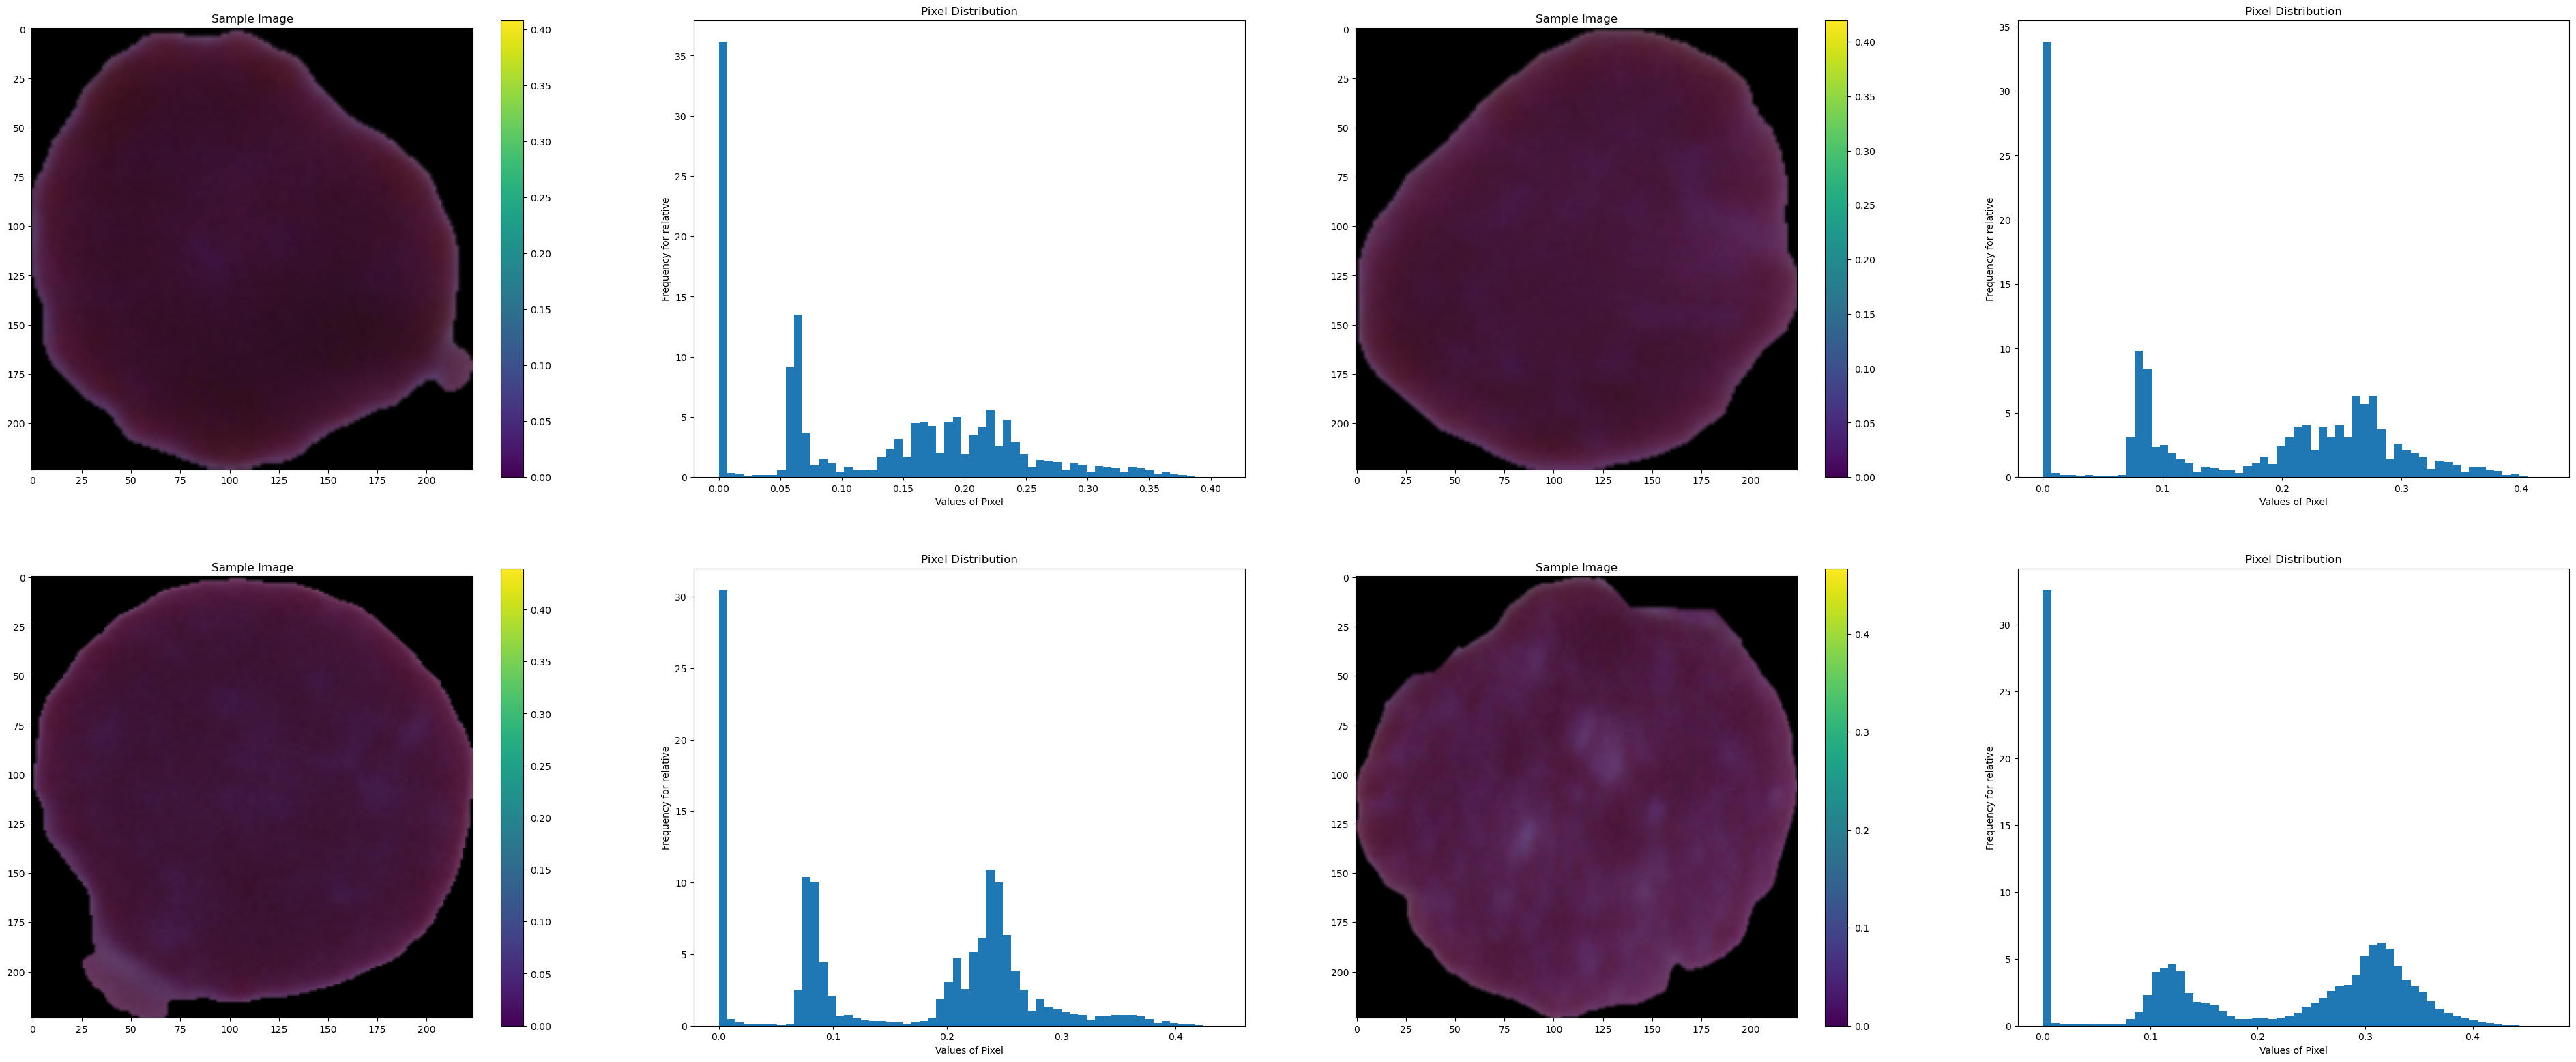

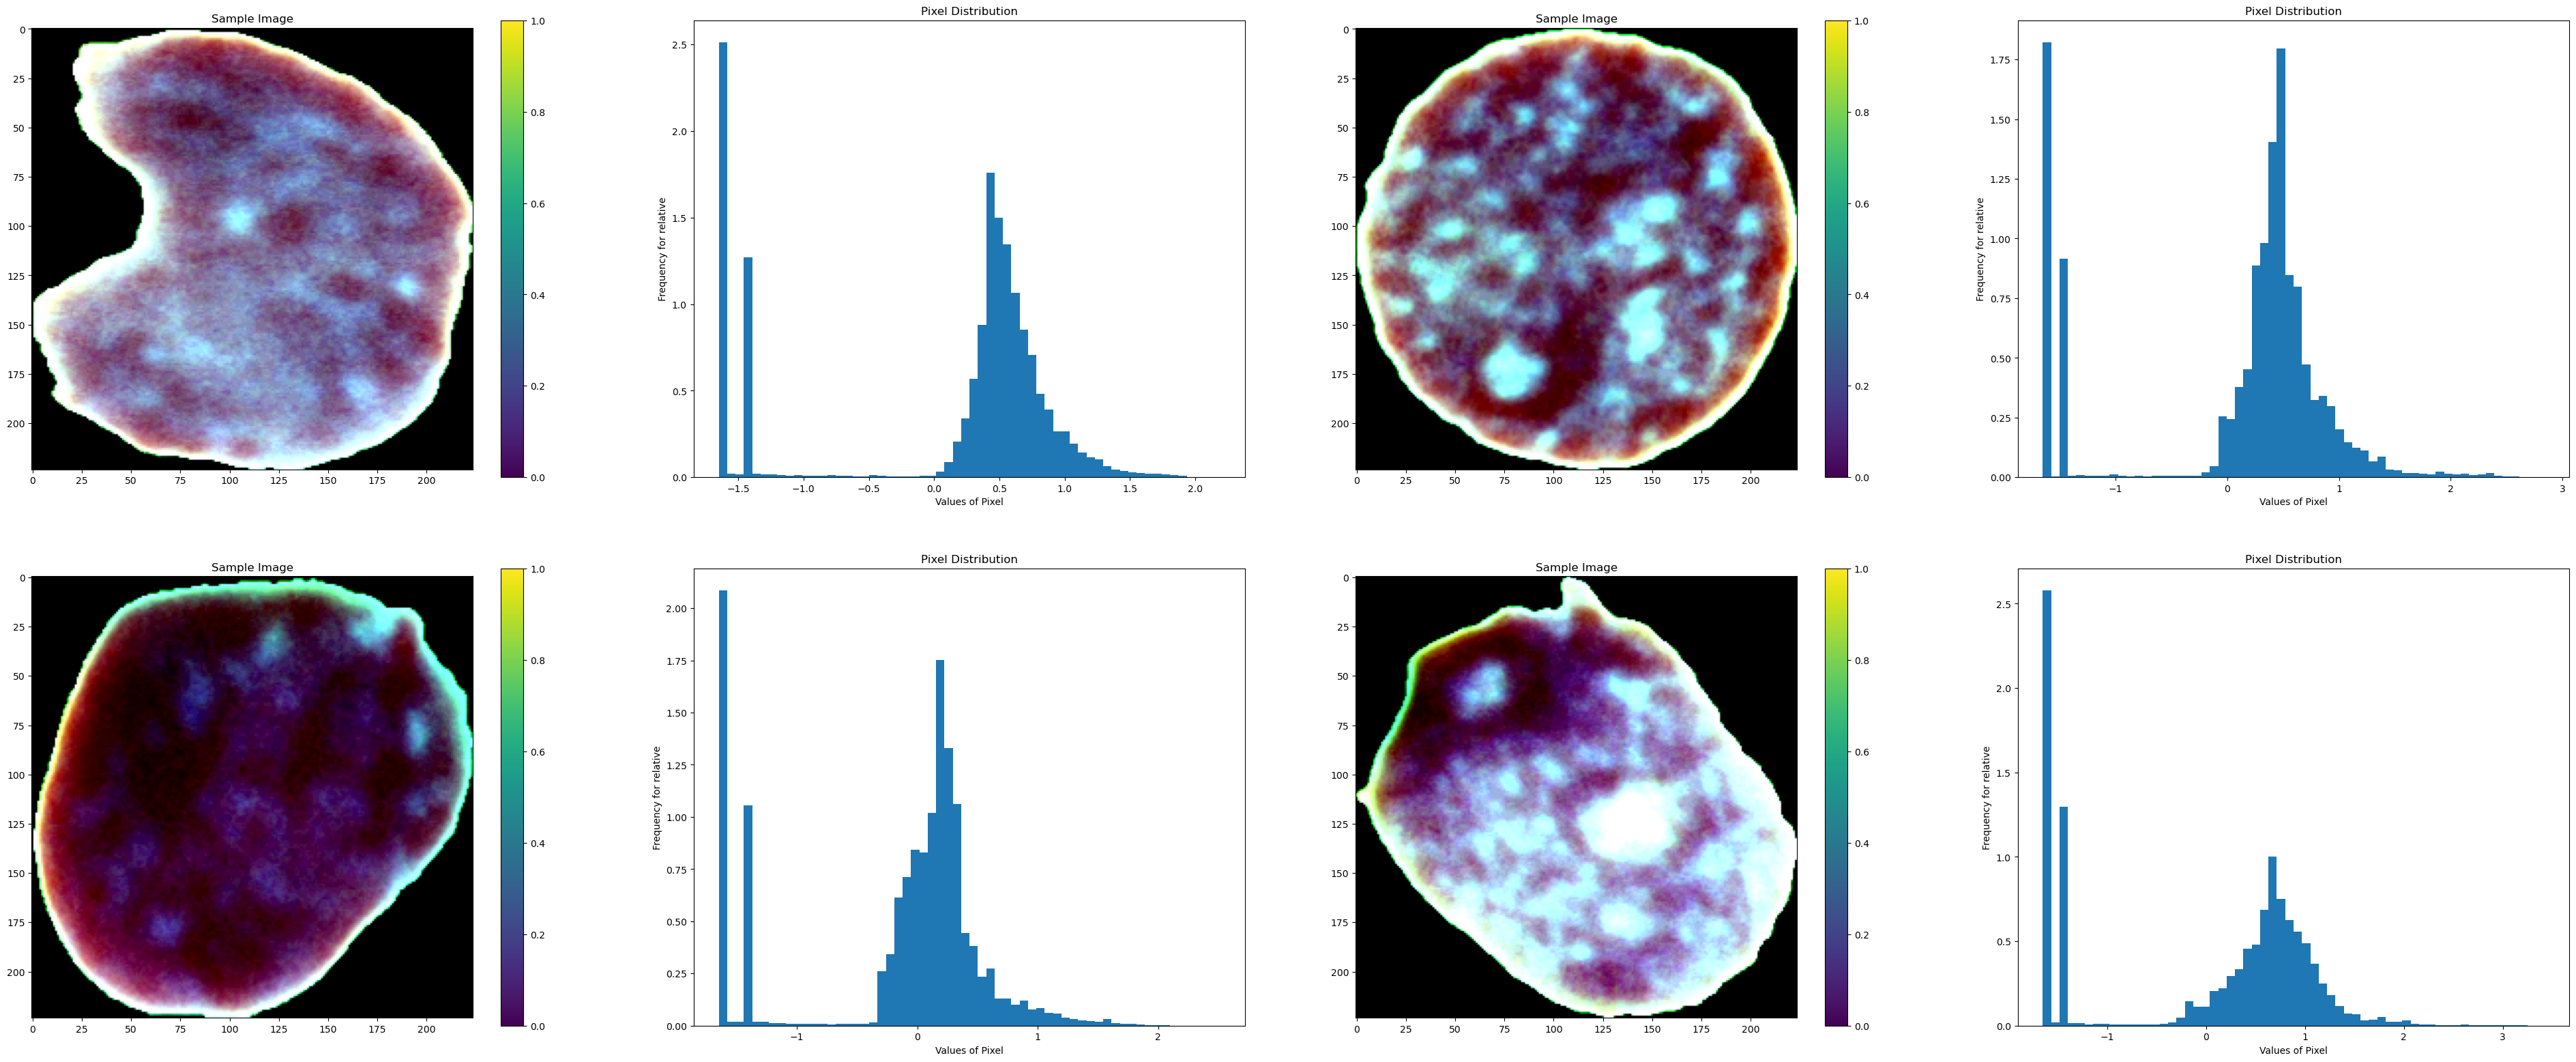

In [14]:
%%capture --no-display

#Images before and afte Processing
plot(8)
plot(8,testloader)

In [10]:
#categories and number of instances
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes = classes[1:3]
print(f"classes = {classes[0], classes[1]}")

train_count=len(glob.glob(train_path+'/**/*.png')) #N.B. we assume that the image has a png format
test_count=len(glob.glob(test_path+'/**/*.png'))

print(f"Total number of training instances:{train_count}; total number of testing instances =  {test_count}")

classes = ('ALL', 'HEM')
Total number of training instances:8725; total number of testing instances =  3803


# Network Architecture

In [11]:
class ConvNet(nn.Module):
    def __init__(self, p_drop = 0.5):
        super(ConvNet,self).__init__()
        
        #First Convolution Layer: Convolution + Batch_Normalization + ReLU + Pool
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        #Second Convolution Layer: Convolution + ReLU
        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
            
        #Third Convolution Layer: Convolution + Batch_Normalization + ReLU
        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        
        #Dropout Layer (Optional)
        self.dropout2 = nn.Dropout(p_drop,inplace = False)
        
        #Fully Connected Layer
        self.fc = nn.Linear(in_features=112 * 112 * 32 ,out_features=1)
        
        
        #Feed forwad function
        
    def forward(self,input):
        
        #First Convolution Layer
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)
        
        #Second Convolution Layer
        output = self.conv2(output)
        output = self.relu2(output)
            
        #Third Convolution Layer: Output --> matrix(64,32,112,112)
        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        
        
        #Fully Connected Layer
        output = output.view(-1,32*112*112)
        output = self.dropout2(output)
        output = self.fc(output)
            
        return output

In [12]:
#Model Structure
model = ConvNet()

model.to("cpu")
summary(model, (3, 224, 224))

#writer = SummaryWriter()
#images, labels = next(iter(trainloader))
#writer.add_graph(model, images)
#writer.close()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 12, 224, 224]             336
       BatchNorm2d-2         [-1, 12, 224, 224]              24
              ReLU-3         [-1, 12, 224, 224]               0
         MaxPool2d-4         [-1, 12, 112, 112]               0
            Conv2d-5         [-1, 20, 112, 112]           2,180
              ReLU-6         [-1, 20, 112, 112]               0
            Conv2d-7         [-1, 32, 112, 112]           5,792
       BatchNorm2d-8         [-1, 32, 112, 112]              64
              ReLU-9         [-1, 32, 112, 112]               0
          Dropout-10               [-1, 401408]               0
           Linear-11                    [-1, 1]         401,409
Total params: 409,805
Trainable params: 409,805
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/

# Training

In [ ]:
#Model Initialization
model = ConvNet(p_drop = 0.95)

#Moving the model to GPU
device = "mps"
model = model.to(device)

#Loss Function --> Binary Cross Entropy with Sigmoid
loss_fn = BCEWithLogitsLoss()

#Learning and weight decay schedules
learning_rate = [0.001] #Choose a Learning Schedule (optimized = 0.001)
weight_decay = [0] #Choose a Weight Decay Schedule (optimized = 0)

#Creating the optimizers for each set of parameters
hyperparameters = [] #The list of parameters
optimizer_list = [] #The list of optimizers
for lrate in learning_rate:
    for w in weight_decay:
        hyperparameters.append([[lrate],[w]])
        optimizer_list.append(Adam(model.parameters(), lr = lrate ,weight_decay = w))
        
        
#Number of epochs
n_epochs = 2


current_acc = 0
for i in range(len(optimizer_list)):
    opt = optimizer_list[i]
    train_step = make_train_step(model, opt, loss_fn)
    print(f"Optimizing for Learning Rate = {hyperparameters[i][0]} and Weight Decay= {hyperparameters[i][1]}")
    best_acc, train_loss, test_loss, train_acc, test_acc, best_model = grid_search_optimization(opt)
    print(f"Best Test Accuracy for Learning Rate = {hyperparameters[i][0]} and Weight Decay= {hyperparameters[i][1]} is {best_acc}")
    
    if best_acc >= current_acc:
        current_acc = best_acc
        torch.save(best_model, 'best-model-scratch.pt') #saving the best model across the grid search
    
    train_loss = np.array(train_loss)
    train_acc = np.array(train_acc)
    test_loss = np.array(test_loss)
    test_acc = np.array(test_acc)
    
    writer = SummaryWriter()

    for n_iter in range(len(train_acc)):
        writer.add_scalar('Loss/train', train_loss[n_iter] , n_iter)
        writer.add_scalar('Loss/test', test_loss[n_iter], n_iter)
        writer.add_scalar('Accuracy/train', train_acc[n_iter], n_iter)
        writer.add_scalar('Accuracy/test', test_acc[n_iter], n_iter)
    
    writer.close()

# Assessing Model Performance

In [ ]:
model = torch.load("best-model-scratch.pt")

In [ ]:
acc, CM = test_model(model,testloader,device)